In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess
import sys
from copy import copy
import scipy
import imageio
sys.path.append("../")

from scipy.stats import norm
import matplotlib.mlab as mlab
from mvgavg import mvgavg

from useful_func import dtw, get_path, plot_warped_timeseries
from useful_func import spectrum_a, spectrum_d
from useful_func import residuals, exp_decay, get_fit, sigmoid, exp_decay_max
from useful_func import gradient_magnitude, gradient_orientation, gaussian_kernel, assign_orientation, crop_center, cconv, get_algae_im
from numpy import genfromtxt

from joblib import Parallel, delayed
from scipy import optimize

import skued

from useful_func import fit_biexp, fit_exp, fit_monoexp

import tifffile as tiff
import random
%matplotlib widget

# Run all

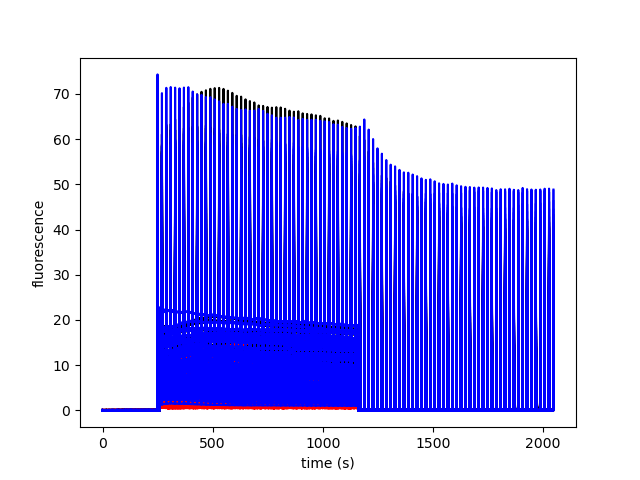

In [2]:
plt.figure()

list_control = np.load("list_control.npy", allow_pickle = True)
list_activated = np.load("list_activated.npy", allow_pickle = True)
list_mix = np.load("list_mix.npy", allow_pickle = True)

mean_control = []
mean_activated = []
mean_mix = []
pixels_control = []
pixels_activated = []
pixels_mix = []
x_coords = [[],[],[]]
y_coords = [[],[],[]]

size_algae = [[],[],[]]


means = [mean_control, mean_activated, mean_mix]
times = [[],[],[]]
pixels = [pixels_control, pixels_activated, pixels_mix]
colors = ["k", "r", "b"]

lists = [list_control, list_activated, list_mix]#, list_mix]

start, stop = 0, -1

video_number = []
algae_number = []


for i, listit in enumerate(lists):
    for j, data in enumerate(listit):
        data = data.item()
        for algae in list(data["items_dict"].keys()):#[:10]:
            y = data["items_dict"][algae]["mean"][start:stop]
            x = data['time'][start:stop]
            
            #inds = y<y.max()*0.4
            inds = y<=y.max()*1
            means[i].append(y[inds])
            times[i].append(x[inds])
            x_coords[i].append(np.mean(data["items_dict"][algae]["x_coords"]))
            y_coords[i].append(np.mean(data["items_dict"][algae]["y_coords"]))
            img_algae = get_algae_im(data["items_dict"][algae]["x_coords"], data["items_dict"][algae]["y_coords"], data['im_ref'])
            size_algae[i].append(data["items_dict"][algae]["surface"])

            pixels[i].append(img_algae)
            plt.plot(x[inds], y[inds], color = colors[i])
            plt.xlabel("time (s)")
            plt.ylabel("fluorescence")
            video_number.append(j)
            algae_number.append(algae)


## validation set

In [3]:
print("control:", len(lists[0][2].item()['items_dict'].keys()))
print("activated:", len(lists[1][2].item()['items_dict'].keys()))

control: 77
activated: 57


### mean response

In [4]:
mm = []
tt = []
pp = []
xx = []
yy = []
ss = []
ll = []
for i, m in enumerate(means):
    mm.append([])
    tt.append([])
    pp.append([])
    xx.append([])
    yy.append([])
    ss.append([])
    
    
    for j, alg in enumerate(m):
        if len(alg)==len(m[0]):
            mm[i].append(alg)
            tt[i].append(times[i][j])
            pp[i].append(pixels[i][j])
            xx[i].append(x_coords[i][j])
            yy[i].append(y_coords[i][j])
            ss[i].append(size_algae[i][j])
            ll.append(i)

In [5]:
plt.

SyntaxError: invalid syntax (457645448.py, line 1)

In [6]:
np.save('traces.npy', mm)
np.save('times.npy', tt)
np.save('images_algae.npy', pp)
np.save('x_coords.npy', xx)
np.save('y_coords.npy', yy)

C:\Users\Alienor\anaconda3\envs\stardist\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


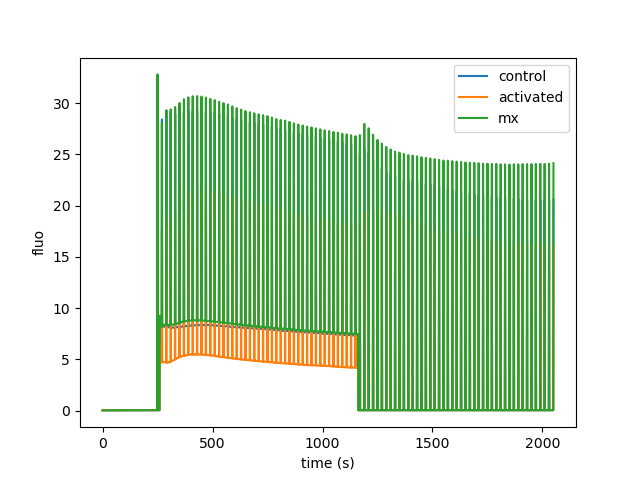

In [7]:
plt.figure()
mean_traces = copy(mm)
for i, m in enumerate(mm): 
    m = np.array(m)
    m = np.mean(m, axis = 0)
    #m = m[m<m.max()*0.4]
    plt.plot(m, label = ['control', 'activated', 'mx'][i])
    mean_traces[i] = m                               
plt.xlabel("time (s)")
plt.ylabel("fluo")
plt.legend()
#control: mm[0]


#activated: mm[1]

In [8]:
mm = []
tt = []
pp = []
xx = []
yy = []
ss = []
ll = []
video_number = []
algae_number = []
for i, m in enumerate(means):
    mm.append([])
    tt.append([])
    pp.append([])
    xx.append([])
    yy.append([])
    ss.append([])
    
    
    for j, alg in enumerate(m):
        if len(alg)==len(m[0]):
            mm[i].append(alg[mean_traces[i]<0.4*mean_traces[i].max()])
            tt[i].append(times[i][j][mean_traces[i]<0.4*mean_traces[i].max()])
            pp[i].append(pixels[i][j])
            xx[i].append(x_coords[i][j])
            yy[i].append(y_coords[i][j])
            ss[i].append(size_algae[i][j])
            ll.append(i)

In [9]:
np.save('traces_clear_pulse.npy', mm)
np.save('times_clear_pulse.npy', tt)
np.save('images_algae.npy', pp)
np.save('x_coords.npy', xx)
np.save('y_coords.npy', yy)
np.save('labels.npy',ll)
np.save(

SyntaxError: unexpected EOF while parsing (3662899991.py, line 7)

In [ ]:
plt.figure()

for j in range(3):
    for i in range(len(mm[j])):
        f0 = mm[j][i][260]
        f1 = mm[j][i][269]

        plt.scatter(i, (f0-f1)/f1, c=["r", "g", "b"][j])

In [ ]:
len(mm[0])

In [ ]:


def fit_monoexp(time, trace, ref):
    inds = ref<ref.max()*0.4
    time = time[inds]
    trace = trace[inds]
    ys = mvgavg(trace, 3)
    start = np.argmin(ys[0:100])
    stop = min(start + np.argmax(ys[start:])+30, len(time)-1)
    
    t = time[start:stop] - time[start]
    y = trace[start:stop]
    half = (3*trace[start] + trace[stop])/4
    xhalf = (start+stop)/2
    
    
    #x0 = [0.03, 0.98, 20, 80]
    #lower_bounds = [-1e9]*len(x0)
    #lower_bounds[1] = 0

    #OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (lower_bounds,1e9),
    #                                args = (t, y, sigmoid))
    #parameters_estimated = OptimizeResult.x
    #xhalf = int(parameters_estimated[-1])
    #print("tau sigmoid", parameters_estimated[1])
    #ypred = sigmoid(parameters_estimated, t)
    """
    plt.figure()
    plt.plot(time, trace)
    plt.scatter(time[start], trace[start])
    plt.scatter(time[xhalf], trace[xhalf])
    plt.scatter(time[stop], trace[stop])
    plt.plot(t+time[start], ypred)
    """
    xeph = np.linspace(start, stop-1, stop-start)
    
    p = np.polyfit(xeph, y, 5)
    #plt.figure()
    #plt.plot(time, trace)
    #plt.plot(time[xeph.astype(int)], np.polyval(p, xeph))
    p[-1] -= half

    roots = np.roots(p)
    roots = roots[np.isreal(roots)]
    

    roots = roots[(roots>start)*(roots<stop)]
    if len(roots)==0:
        return trace, time, trace, time, None, None, None, None
    else:
        root = roots[np.argmin(np.sqrt((roots-xhalf)**2))]
        xhalf = int(root)

        #plt.scatter(root, half)

        x0 = [1,1,1]
        lower_bounds = [-1e9]*len(x0)
        lower_bounds[1] = 0
        t = time[xhalf:stop] - time[xhalf]
        y = trace[xhalf:stop]
        OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (lower_bounds,1e9),
                                        args = (t, y, exp_decay))    

        parameters_estimated = OptimizeResult.x
        #print("tau exp", parameters_estimated[1])

        ypred = exp_decay(parameters_estimated, t)
        plt.plot(t+time[xhalf], ypred)

        A0, tau0, y0 = parameters_estimated


        return trace, time, ypred, t+time[xhalf], (trace[stop]-trace[start])/trace[stop], tau0, y0, A0



def fit_exp(xdata, trace, ref):
    x0 = [1,1,1]
    inds = ref<ref.max()*0.4
    time = xdata[inds]
    start = np.argmax(trace[0:2])
    y = trace[inds][start:]
    ys = mvgavg(trace, 3)
    t0 = time[start]
    time = time[start:] - t0
    lower_bounds = [-1e9]*len(x0)
    lower_bounds[1] = 0
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (lower_bounds,1e9),
                                    args = (time,y , exp_decay_max))
    parameters_estimated = OptimizeResult.x
    ypred = exp_decay_max(parameters_estimated, time)
    
    tau = parameters_estimated[1]
    duration = time[-1]-time[0]
    convert = duration/len(time)
    if tau >  duration//2: #if too high
            tau =  duration//2
    if tau < 5: #if too low, increase it
            tau = 5
    x0 = parameters_estimated #initial guess: parameters from previous fit
    #second fit
    
    bound = int(tau*5/convert)
    #print(bound)
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (lower_bounds,1e9),
                                    args = (time[0:bound],y[0:bound] , exp_decay_max))
    ypred = exp_decay_max(parameters_estimated, time)
    
    A, tau, y0 = parameters_estimated

    return trace[inds], xdata[inds]-xdata[start], ypred, time + t0, (trace[start]-trace[-1])/trace[start], tau, y0, A


def exp_decay_max(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]- xdata[0]
    tau = parameters[1]
    y0 = parameters[2] - xdata[0]
    return A * np.exp(-xdata/tau) + y0



In [ ]:
for start, stop, function_to_fit in [(260, 280, fit_exp),(280, 600, fit_biexp), (280, 600, fit_monoexp)]:

    ref = mean_traces[0][start:stop]
    y, time, ypred, timepred,  *parameters_estimated = function_to_fit(tt[0][j][start:stop], ref/ref.mean(), ref)
    print(parameters_estimated)
    plt.figure()
    plt.plot(time, y , label = "control, tau = %0.2f, %0.2f"%(parameters_estimated[1], parameters_estimated[-1]))
    plt.plot(timepred, ypred)

    ref = mean_traces[1][start:stop]
    y, time, ypred, timepred, *parameters_estimated = function_to_fit(tt[1][j][start:stop], ref/ref.mean(), ref)

    plt.plot(time, y, label = "activated, tau = %0.2f, %0.2f"%(parameters_estimated[1], parameters_estimated[-1]))
    plt.plot(timepred, ypred)

    plt.xlabel("time (s)")
    plt.ylabel("mean fluo of algae in all videos")

    plt.legend()

# Classification with fits

In [ ]:
def get_ind(output, ind):
    r = []
    for i in range(len(output)):
        if output[i][ind]!= None:
            r.append(output[i][ind])
    return np.array(r).astype(float)

def get_ind_pos(output, ind):
    r = []
    for i in range(len(output)):
        if output[i][ind]!= None:
            r.append(i)
    return np.array(r).astype(int)

#qT control
start, stop = 280, 600
k = 0
x = mean_traces[k][start:stop]
signal = mm[0]
output1 = np.array(Parallel(n_jobs=-1)(delayed(fit_monoexp)(tt[k][j][start:stop], signal[j][start:stop], x) for j in range(len(signal))))
t1 = get_ind(output1, -3)
y1 = get_ind(output1, -2)
A1 = get_ind(output1, -1)
ind1 = get_ind_pos(output1, -1)
val1 = -A1/y1

r1 = get_ind(output1,-4)

#qE control
start, stop = 260, 272
x = mean_traces[k][start:stop]

output2 = Parallel(n_jobs=-1)(delayed(fit_exp)(tt[k][j][start:stop], signal[j][start:stop], x) for j in range(len(signal)))
t2 = get_ind(output2, -3)
y2 = get_ind(output2, -2)
A2 = get_ind(output2, -1)
val2 =  A2/y2
r2 = get_ind(output2,-4)

#qT activated
k = 1
signal = mm[1]#goodboys
start, stop = 280, 600
x = mean_traces[k][start:stop]


output3 = Parallel(n_jobs=-1)(delayed(fit_monoexp)(tt[k][j][start:stop], signal[j][start:stop], x) for j in range(len(signal)))
t3 = get_ind(output3, -3)
y3 = get_ind(output3, -2)
A3 = get_ind(output3, -1)
val3 = -A3/y3
r3 = get_ind(output3,-4)
ind3 = get_ind_pos(output3, -1)

#qE activated
start, stop = 260, 272
x = mean_traces[k][start:stop]

output4 = Parallel(n_jobs=-1)(delayed(fit_exp)(tt[k][j][start:stop], signal[j][start:stop], x) for j in range(len(signal)))
t4 = get_ind(output4, -3)
y4 = get_ind(output4, -2)
A4 = get_ind(output4, -1)
val4 = A4/y4
r4 = get_ind(output4,-4)

#qT activated
k = 2
signal = mm[2]
start, stop = 280, 600
x = mean_traces[k][start:stop]


output5 = Parallel(n_jobs=-1)(delayed(fit_monoexp)(tt[k][j][start:stop], signal[j][start:stop], x) for j in range(len(signal)))
t5 = get_ind(output5, -3)
y5 = get_ind(output5, -2)
A5 = get_ind(output5, -1)
val5 = -A5/y5
r5 = get_ind(output5,-4)
ind5 = get_ind_pos(output5, -1)

#qE activated
start, stop = 260, 272
x = mean_traces[k][start:stop]

output6 = Parallel(n_jobs=-1)(delayed(fit_exp)(tt[k][j][start:stop], signal[j][start:stop], x) for j in range(len(signal)))
t6 = get_ind(output6, -3)
y6 = get_ind(output6, -2)
A6 = get_ind(output6, -1)
val6 = A6/y6
r6 = get_ind(output6,-4)



def normalize(t, lim_low, lim_high, n = True):
    t = np.array(t)
    t = t[(t>=lim_low)*(t<lim_high)]
    if n == True:
        return t/t.mean()
    else:
        return t
    
def plot_law(ax, tau, label, lim_low, lim_high, n=True):
    tau = normalize(tau, lim_low, lim_high, n)
    (mu, sigma) = norm.fit(tau)
    n, bins, patches = ax.hist(tau, bins = 50, label = label + " nb algae: " + str(len(tau)), density=1)#, range = (lim_low,lim_high))
    normale = norm.pdf( bins, mu, sigma)
    ax.plot(bins, normale, '--', linewidth=2, label = label)
   
    ax.legend()
    

qTmin = -0.5
qTmax = 1.25
qEmin = -0.5
qEmax = 1.25


#qTmin = 0
#qTmax = 150
#qEmin = 0
#qEmax = 10

fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0][0].set_title("compare control distributions")
ax[0][0].set_xlabel("amp/<amp>")
plot_law(ax[0][0], val1, 'control qT', qTmin, qTmax, True)
plot_law(ax[0][0], val3, 'control qE', qEmin, qEmax, True)
ax[0][1].set_title("compare activated distributions")
ax[0][1].set_xlabel("amp/<amp>")
plot_law(ax[0][1], val2, 'activated qT',  qTmin, qTmax, True)
plot_law(ax[0][1], val4, 'activated qE', qEmin, qEmax, True)
ax[1][0].set_title("compare qT distributions")
ax[1][0].set_xlabel("amp")
plot_law(ax[1][0], val1, 'control qT',  qTmin, qTmax, False)
plot_law(ax[1][0], val3, 'activated qT', qTmin, qTmax, False)
ax[1][1].set_title("compare qE distributions")
ax[1][1].set_xlabel("amp")

plot_law(ax[1][1], val2, 'control qE', qEmin, qEmax, False)
plot_law(ax[1][1], val4, 'activated qE', qEmin, qEmax, False)


In [10]:
def make_inds(list_ref, qTmin, qTmax, qEmin, qEmax):
    inds0 = (list_ref[:,0]>qTmin)*(list_ref[:,0]<qTmax)
    inds1 = (list_ref[:,1]>qEmin)*(list_ref[:,1]<qEmax)
    inds2 = (list_ref[:,2]>0)*(list_ref[:,2]<6)
    inds3 = (list_ref[:,3]>0)*(list_ref[:,3]<170)
    inds_train = inds0*inds1*inds2*inds3
    return inds_train

ERROR! Session/line number was not unique in database. History logging moved to new session 8014


In [11]:
from useful_func import make_svm, make_pca


ll = np.array(ll)
video_number = np.array(video_number)
remake_video_number = []
cont = video_number[ll==0]
cont = cont[ind1]
remake_video_number.append(cont)
cont = video_number[ll==1]
cont = cont[ind3]
remake_video_number.append(cont)
cont = video_number[ll==2]
cont = cont[ind5]
remake_video_number.append(cont)
remake_video_number = np.concatenate(remake_video_number)

list_ref = np.array([np.concatenate(((A2/(y2))[ind1], (A4/(y4))[ind3], (A6/(y6))[ind5])), np.concatenate((-A1/y1, -A3/y3, -A5/y5)),
                     np.concatenate((t2[ind1],t4[ind3],t6[ind5])), np.concatenate((t1,t3, t5))]).T

algae_number = np.array(algae_number)
algae_test = np.array(np.concatenate([algae_number[ll==0][ind1], algae_number[ll==1][ind3], algae_number[ll==2][ind5]]))

inds_train = make_inds(list_ref, qTmin, qTmax, qEmin, qEmax)

label0 = np.array([0]*len(t1) + [1]*len(t3)+[2]*len(t5))
list_ref = list_ref[inds_train]
algae_test = algae_test[inds_train]

obj_kept =  np.mean(inds_train[label0<2])

label = label0[inds_train]

print("objects kept:", obj_kept)
training_set = label<2
#p = 0.85
#train_split = np.random.choice(a=[True, False], size=np.sum(training_set), p=[p, 1-p])
train_split = np.ones(np.sum(training_set))
remake_video_number = remake_video_number[inds_train]
train_split[remake_video_number[training_set]==1] = 0
list_ref_svm = (list_ref - np.mean(list_ref, axis = 0))/np.std(list_ref, axis = 0)
list_ref_svm_fits = np.copy(list_ref_svm)
labels_fits = np.copy(label)
train_data_nosplit = list_ref_svm[training_set.T]
train_data = train_data_nosplit[train_split==1]
Y_train_label = label[training_set][train_split==1]
Y_train_label_fits = np.copy(Y_train_label)


final_model = make_svm(train_data, Y_train_label)

pca = make_pca(list_ref.shape[-1], train_data, Y_train_label)

X = pca.transform(train_data)
    
xmin, xmax = X[:,0].min()*2, X[:,0].max()
ymin, ymax = X[:,1].min()*2, X[:,1].max()

plt.figure()
X = pca.transform(train_data)
X_fits = np.copy(X)
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
validation_data = train_data_nosplit[train_split==0]
Y_val_label = label[training_set][train_split==0]

Yval_data = final_model.predict(validation_data)
Xval =  pca.transform(validation_data)
plt.scatter(Xval[:, 0], Xval[:, 1], c=Y_val_label)##
print("number of points train:", len(train_data))
print("number of points validation:", len(validation_data))
      
print("accuracy validation:", np.mean(Y_val_label==Yval_data))
      
    
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)
position = (label==2)
test_data = (list_ref_svm)[position.T]
algae_test = algae_test[position]

Y_data = final_model.predict(test_data)

X2 = pca.transform(test_data)
X2_fits = np.copy(X2)

for k in range(0,3):
    #plt.figure()
    position = (label==2)*(remake_video_number==k)
    test_data = (list_ref_svm)[position.T]
    Yd = final_model.predict(test_data)

    X2 = pca.transform(test_data)

    plt.scatter(X2[:,0], X2[:,1], c=Yd)
    print(np.sum(Yd)/len(Yd))
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    

print("test predction:", np.sum(Yd)/len(Yd))
plt.xlabel("PC1")
plt.ylabel("PC2")


fig, axs = plt.subplots(2,2,figsize=(12,10))
ranges = [(qEmin, qEmax),(qTmin, qTmax), (0,6), (0,150)]
for i, ax in enumerate(axs.flatten()):
    for j in range(2):
        data_hist = list_ref[:,i][label==j]
        ax.hist(data_hist, bins=30, range = ranges[i], label = ['control, num algae = %d'%len(data_hist), 'activated, num algae = %d'%len(data_hist)][j])
        
        ax.set_xlabel(["qE A/y0", "qT A/y0", "qE tau", "qT tau"][i])
        ax.legend()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 419

## Classification with ratios

In [ ]:
#plt.figure(figsize=(10,10))
lists = [list_control, list_activated, list_mix]
colors = [(1.0, 0.0, 0.0, 1.0), (0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 1.0, 1.0)]
N = [0,0,0]


label = []
r1 = []
r2 =  []
r3 = []
r4 = []
r5 = []
r6 = []
r7 = []
r0  = []
video_number = []
color = []
for i, listit in enumerate(lists):
    for j, data in enumerate(listit):
        data = data.item()
        for algae in data["items_dict"].keys():
            N[i]+=1
            y = data["items_dict"][algae]["mean"]
            r0.append((y[260] - y[269])/y[269])
            r1.append((-y[271]+y[453])/y[453])
            r2.append((y[250]-y[270])/y[270])
            r3.append((-y[270]+y[450])/y[450])
            r4.append(y[270])
            r5.append(y[450])
            r6.append(y[1150])
            r7.append(y[1190])
            color.append(colors[i])
            label.append(i)
            inds = (y < y.max()*0.4)
            
            #plt.scatter(r1, r2, color = colors[i])
            #plt.xlabel("ratio qE")
            #plt.ylabel("ratio qT")
            #ax.scatter(r1,r2,r3, c = colors[i])
            video_number.append(j)



def cm(r):
    return np.array(r)#(r-np.mean(r))/(2*np.std(r))



color = np.array(color)
label = np.array(label)
video_number = np.array(video_number)

"""
nodes = points3d(r1, r2, r3, colormap="copper", scale_factor=.01)
nodes.glyph.scale_mode = 'scale_by_vector'

nodes.mlab_source.dataset.point_data.scalars = color
"""

list_ref = np.array([cm(r0), cm(r1)]).T#,cm(r4), cm(r5), cm(r6), cm(r7)]).T
list_ref_svm = (list_ref - np.mean(list_ref, axis = 0))/np.std(list_ref, axis = 0)

training_set = label<2
train_split = (video_number != 1)
validation_split = (video_number==1)
train_data = list_ref_svm[(training_set*train_split).T]
Y_train_label = label[training_set*train_split]



final_model = make_svm(train_data, Y_train_label)

pca = make_pca(list_ref.shape[-1], train_data, Y_train_label)

    
X = pca.transform(train_data)


plt.figure()
X = pca.transform(train_data)
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
validation_data = list_ref_svm[(training_set*validation_split).T]
Y_val_label = label[training_set*validation_split]

Yval_data = final_model.predict(validation_data)
Xval =  pca.transform(validation_data)
plt.scatter(Xval[:, 0], Xval[:, 1], c=Y_val_label)##
print("number of points train:", len(train_data))
print("number of points validation:", len(validation_data))
      
print("accuracy validation:", np.mean(Y_val_label==Yval_data))
      
    
plt.figure()
X = pca.transform(train_data)
X2 = pca.transform(list_ref_svm[label==2])
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
for k in range(0,3):
    #plt.figure()
    position = (label==2)*(video_number==k)
    test_data = (list_ref_svm)[position.T]
    Yd = final_model.predict(test_data)

    Xbis = pca.transform(test_data)

    plt.scatter(Xbis[:,0], Xbis[:,1], c=Yd)
    print(np.sum(Yd)/len(Yd))
    plt.xlabel("PC1")
    plt.ylabel("PC2")

fig = plt.figure()


ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
labs =  label[(label!=2)*train_split]
#for cat in [0,1]:
#    ax.scatter(X[labs==cat,0],X[labs==cat,1],X[labs==cat,2], marker = ".", color = ["k", "r"][cat])

Ytot = []
for k in range(0,3):
    #plt.figure()
    position = (label==2)*(video_number==k)
    test_data = list_ref_svm[position.T]
    Yd = final_model.predict(test_data)
    Ytot.append(Yd)
    print(np.sum(Yd)/len(Yd))

    Xbis = pca.transform(test_data)
    #ax.scatter(Xbis[:,0], Xbis[:,1],Xbis[:,2], color = ["b"])
    
np.save("ydata_ratio.npy", np.concatenate(Ytot))

In [ ]:
algae_number=np.array(algae_number)
vid = video_number[ll==2][ind5][inds_train[label0==2]]
alg = algae_number[ll==2][ind5][inds_train[label0==2]]


In [ ]:
np.mean(Yd0)

In [ ]:
ll = np.array(ll)
Yd0 = np.concatenate(Ytot)
Yd = Yd0[ind5][inds_train[label0==2]]
X2 = X2[ind5][inds_train[label0==2]]
print("mismatch:", np.sum(Yd!=Y_data))
print("total:", len(Yd))

fig, ax = plt.subplots(3,1, figsize=(8,15))
ax[0].pie([np.sum(Yd0==0), np.sum(Yd0==1)], labels = ["control", "activated"], autopct = '%1.1f%%')
ax[0].set_title("classification from ratios")
ax[1].pie([np.sum(Y_data==0), np.sum(Y_data==1), len(Yd0)-len(ind5), len(ind5)-len(Y_data)], labels = ["control", "activated", "fit failed", "out of range fit"], autopct = '%1.1f%%')
ax[1].set_title("classification from fits")
ax[2].pie([np.sum(Yd==Y_data), np.sum(Yd != Y_data), np.sum(len(Yd0) - len(Y_data))], labels = ["prediction match", "mismatch", "discarded by fit"], autopct = '%1.1f%%')
ax[2].set_title("compare classifications")


In [ ]:
for pos, boo in enumerate(Yd != Y_data):
    if boo == True:
        plt.figure()
        data = list_mix[vid[pos]].item()
        trace = data["items_dict"][alg[pos]]["mean"]
        plt.plot(trace)
        plt.title("pred ratio: %d, pred fit: %d"%(Yd[pos], Y_data[pos]))
        #plt.figure()
        #im = get_algae_im(data["items_dict"][alg[pos]]["x_coords"], data["items_dict"][alg[pos]]["y_coords"], data['im_ref'])
        #plt.imshow(im)
        for start, stop, function_to_fit in [(260, 290, fit_exp), (280, 600, fit_monoexp)]:

            trace0 = trace[start:stop]
            ref =  mean_traces[2][start:stop]

            y, time, ypred, timepred,  *parameters_estimated = function_to_fit(tt[2][j][start:stop], trace0, ref)
            print(parameters_estimated)
            #plt.plot(time, y , label = "control, tau = %0.2f, %0.2f"%(parameters_estimated[1], parameters_estimated[-1]))
            plt.plot(timepred, ypred)

            plt.xlabel("time (s)")
            plt.ylabel("mean fluo of algae in all videos")

            plt.legend()
            
            
            signal = mm[2]




In [ ]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
diff_ind = Yd != Y_data
plt.scatter(X2[diff_ind, 0], X2[diff_ind, 1], c = Yd[diff_ind])
plt.figure()
plt.scatter(X_fits[:, 0], X_fits[:, 1], c=Y_train_label_fits, alpha = 0.1, edgecolor='none')##
plt.scatter(X2_fits[diff_ind, 0], X2_fits[diff_ind, 1], c = Y_data[diff_ind])


### Correlations

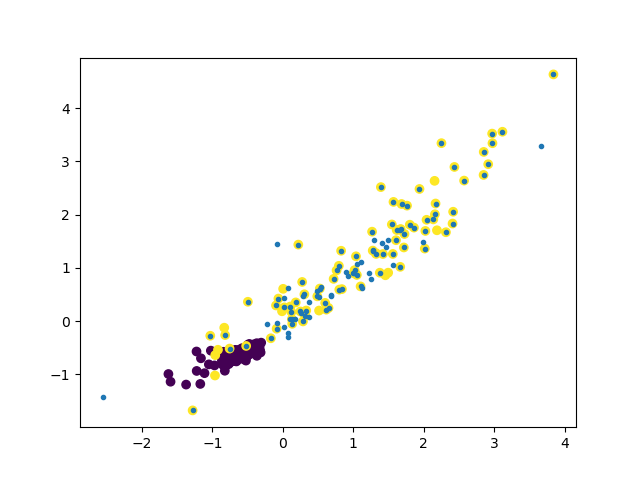

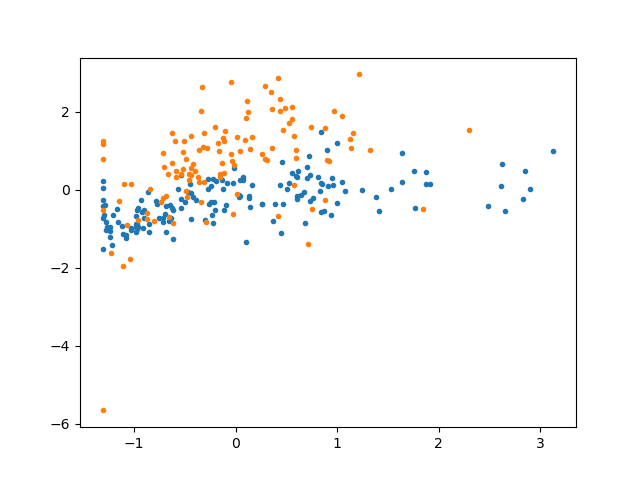

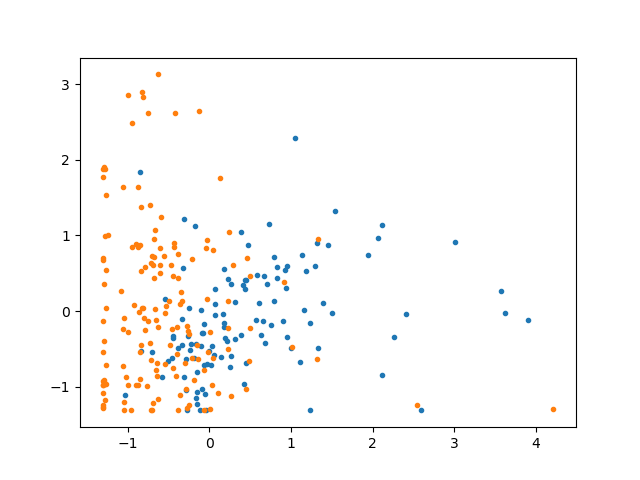

In [172]:
plt.figure()
plt.scatter(train_data[:,0], train_data[:,2],c=Y_train_label)
plt.scatter(list_ref_svm[ll==1][ind3][inds_train[label0==1]][:,0], list_ref_svm[ll==1][ind3][inds_train[label0==1]][:,2], marker = '.')

plt.figure()
plt.scatter(list_ref_svm_fits[labels_fits==0,3], list_ref_svm[ll==0][ind1][inds_train[label0==0]][:,1], marker = '.')
plt.scatter(list_ref_svm_fits[labels_fits==1,3], list_ref_svm[ll==1][ind3][inds_train[label0==1]][:,1], marker = '.')
plt.figure()
plt.scatter(list_ref_svm_fits[labels_fits==1,2], list_ref_svm_fits[labels_fits==1,3], marker = '.')
plt.scatter(list_ref_svm_fits[labels_fits==0,2], list_ref_svm_fits[labels_fits==0,3], marker = '.')


In [160]:
len(list_ref_svm_fits[labels_fits==0])

156

419